## Naive Bayes

Our task for today will be to classify emails as spam or not spam. We sill use the Enron Email Dataset. The dataset contains email text along with a label of whether that text was spam or not.

First, let's load the dataset, and look at an example too!

**(Run this cell to define useful Latex macros)**
\\[
\newcommand{\card}[1]{\left\lvert#1\right\rvert}
\newcommand{\condbar}[0]{\,\big|\,}
\newcommand{\eprob}[1]{\widehat{\text{Pr}}\left[#1\right]}
\newcommand{\norm}[1]{\left\lvert\left\lvert#1\right\rvert\right\rvert}
\newcommand{\prob}[1]{\text{Pr}\left[#1\right]}
\\]

In [1]:
%matplotlib inline
import lib.download
lib.download.run()

import lib.dataset
RAW_DATASET = lib.dataset.RawDataset.get()

print()
print(">>> HAM EMAIL:")
print("=" * 72)
print(RAW_DATASET.ham_emails[5].text_content())

print()
print(">>> SPAM EMAIL:")
print("=" * 72)
print(RAW_DATASET.spam_emails[10].text_content())

Tarfile already downloaded!
Tarfile already extracted!
Dataset already processed!

>>> HAM EMAIL:
Subject: mcmullen gas for 11 / 99
jackie ,
since the inlet to 3 river plant is shut in on 10 / 19 / 99 ( the last day of
flow ) :
at what meter is the mcmullen gas being diverted to ?
at what meter is hpl buying the residue gas ? ( this is the gas from teco ,
vastar , vintage , tejones , and swift )
i still see active deals at meter 3405 in path manager for teco , vastar ,
vintage , tejones , and swift
i also see gas scheduled in pops at meter 3404 and 3405 .
please advice . we need to resolve this as soon as possible so settlement
can send out payments .
thanks

>>> SPAM EMAIL:
Subject: re : rdd , the auxiliary iturean
free cable @ tv
dabble bam servomechanism ferret canopy bookcase befog seductive elapse ballard daphne acrylate deride decadent desolate else sequestration condition ligament ornately yaqui giblet emphysematous woodland lie segovia almighty coffey shut china clubroom diagno

You can see that the email text is all lower case, and each *token* (words, but also symbols like "@") is seperated by a space. The subject line is not technically part of the email body, but I will leave it in anyway.

For the purposes of our algorithm, we will convert emails into a set of words, throwing away the order of the words, and also how frequently they occur in the email. Every token will be represented with an integer, rather than the word itself.

We will represent whether an email is spam or not with a 1 for spam and a 0 for not spam. This is called the *label*.

In [2]:
print(RAW_DATASET.spam_emails[10].codes)
print(RAW_DATASET.spam_emails[10].words())
print(RAW_DATASET.spam_emails[10].label)

SortedSet([0, 7, 13, 27, 69, 209, 306, 679, 1076, 1466, 1492, 3200, 3498, 3880, 4518, 5332, 5673, 6040, 6075, 7845, 10796, 11378, 11981, 12835, 14532, 16407, 17924, 20486, 20487, 20488, 20489, 20490, 20491, 20492, 20493, 20494, 20495, 20496, 20497, 20498, 20499, 20500, 20501, 20502, 20503, 20504, 20505, 20506, 20507, 20508, 20509, 20510, 20511, 20512, 20513, 20514, 20515, 20516, 20517, 20518, 20519, 20520, 20521, 20522, 20523, 20524], key=None, load=1000)
SortedSet([',', ':', '@', 'Subject:', 'abominate', 'acrylate', 'alexander', 'almighty', 'annette', 'auxiliary', 'ballard', 'bam', 'banks', 'befog', 'bookcase', 'byroad', 'cable', 'cambric', 'canadian', 'canopy', 'charlie', 'cheer', 'china', 'cloister', 'clubroom', 'coffey', 'condition', 'contiguous', 'dabble', 'daphne', 'decadent', 'depressive', 'deride', 'desolate', 'diagnostician', 'elapse', 'else', 'emphysematous', 'ferret', 'free', 'giblet', 'gnaw', 'iturean', 'leadsman', 'lie', 'ligament', 'mania', 'oligarchy', 'ornately', 'quake

We call the preprocessing of the dataset *featurization*. The machine learning algorithm will interact with the *featurized* emails (the set of numbers and the 0/1 label), rather than the raw emails themselves.

Featurization is an important part of data preparation. For instance, we saw previously in the linear regression notebooks that it was very helpful to normalize the mean and variance of continuous valued variables. Other featurization techniques are to lowercase words, to normalize whitespace. Sometimes *stemming* is done: this tries to normalize a word like "robots" to "robot", removing the "s". The "stem" is the base word. This is done because often the plethora of minor variants of words can be confusing to ML algorithms.

It is not uncommon to throw away word order and word counts. This representation of text is called the *bag of words model*. Obviously a lot of information is lost with this representation. For some tasks like document retrieval based on keyword matching, the bag of words model can still be useful. For tasks like spam/not-spam bag of words performs well.

For tasks which need deeper *semantic* understanding of a document (understanding what it means), we would want to use techniques which can exploit the information contained in the word ordering.

### Word Probabilities

To detect which emails are spam and which aren't, we will use the observation that some words are more probable to appear in a spam email rather than in a non-spam email. For instance, I suspect that "offer" is more probable to appear in a spam email than a non-spam email. In notation:

\\[
\prob{\text{OFFER} = 1 \condbar \text{SPAM} = 1}
>
\prob{\text{OFFER} = 1 \condbar \text{SPAM} = 0}
\\]

Now, what I really want to know is what is the probability that an email is spam if it contains the word "offer". That is, I want to calculate:

\\[
\prob{\text{SPAM} = 1 \condbar \text{OFFER} = 1}
\\]

To do so, I will use *Bayes' Rule*:

\\[
\prob{\text{SPAM} = 1 \condbar \text{OFFER} = 1}
=
\frac{
    \prob{\text{SPAM} = 1 \wedge \text{OFFER} = 1}
}{
    \prob{\text{OFFER} = 1}
}
=
\frac{
    \prob{\text{SPAM} = 1}
    \cdot
    \prob{\text{OFFER} = 1 \condbar \text{SPAM} = 1}
}{
    \prob{\text{OFFER} = 1}
}
\\]

It is frequently convenient to consider the *odds* that something is true, rather than the probability. If the probability of $X$ is $p$, then the *odds* of $X$ are $\frac{p}{1-p}$. For instance, a probability of $0.66$ corresponds to an odds of $2$, sometimes written $2:1$.

To calculate the odds that an email is spam if it has the word offer in it, first apply Bayes' Rule again to the probability that the email is not spam:

\\[
\prob{\text{SPAM} = 0 \condbar \text{OFFER} = 1}
=
\frac{
    \prob{\text{SPAM} = 0}
    \cdot
    \prob{\text{OFFER} = 1 \condbar \text{SPAM} = 0}
}{
    \prob{\text{OFFER} = 1}
}
\\]

Last, let's compute the odds:

\\[
\frac{
    \prob{\text{SPAM} = 1 \condbar \text{OFFER} = 1}
}{
    \prob{\text{SPAM} = 0 \condbar \text{OFFER} = 1}
}
=
\frac{
    \prob{\text{SPAM} = 1}
}{
    \prob{\text{SPAM} = 0}
}
\cdot
\frac{
    \prob{\text{OFFER} = 1 \condbar \text{SPAM} = 1}
}{
    \prob{\text{OFFER} = 1 \condbar \text{SPAM} = 0}
}
\\]

The second factor in the product I will call the *feature probability ratio*. It is the ratio in feature probability conditional on $SPAM = 1$ versus when $SPAM = 0$.

Alright! Let's do this with code!

In [3]:
import lib.dataset
RAW_DATASET = lib.dataset.RawDataset.get()

feature_probabilities = RAW_DATASET.feature_probabilities()
feature_probabilities.code_prob_ratio(
    code = RAW_DATASET.word_encoding_dictionary.word_to_code('offer')
)

{'feature_probability_ratio': 4.154271138165185}

What this shows is that the odds that an email is spam are $4.15$ times greater if we know that it contains the word "offer."

### Empirical Quantities Can Be Inaccurate

**TODO**: Careful about the use of the word odds here.
To calculate the odds, we are using the counts observed in the dataset. We call this the *empirical* odds: empirical means "known from experience or observation." Likewise, an *empirical* probability is one calculated using observed data.

When there isn't very much data, an empirical quantity will be suspect. See below!

In [4]:
import lib.dataset
RAW_DATASET = lib.dataset.RawDataset.get()

code = RAW_DATASET.word_encoding_dictionary.word_to_code('bacterial')

print(f"Counts | {feature_probabilities.code_counts[code]}")
print(f"Feature Probability Ratio | {feature_probabilities.code_prob_ratio(code)}")

Counts | {'ham_count': 0, 'spam_count': 1}
Feature Probability Ratio | {'feature_probability_ratio': inf}


In our dataset, only one email had the word "bacterial" in it. It was a spam email. Therefore, the empirical probability:

\\[
\eprob{\text{SPAM} = 1 \condbar \text{BACTERIAL} = 1} = 1.0\\
\eprob{\text{SPAM} = 0 \condbar \text{BACTERIAL} = 1} = 0.0
\\]

Here I'm trying to make clear that this probability is an *estimate* of the *true* probability using the empirical probability. Nobody thinks that the presence of the word "bacteria" guarantees an email is spam. In a case like this where the *reach* of a feature is only one example, the empirical probability can only be either $0.0$ or $1.0$. Both examples are completely extreme.

Even though the empirical probability to converge to the true probability with more observations, the empirical probability may be very wrong when the sample size is low.

### Discarding Low Reach Features

How do we deal with this problem? There is more than one way. Let's adopt the simplest: let's throw away all features with a reach of less than twenty examples.

To verify that the remaining features seem to be good, let's look at the top indicators that an email is spam.

In [5]:
import lib.dataset
RAW_DATASET = lib.dataset.RawDataset.get()

filtered_feature_probabilities = RAW_DATASET.feature_probabilities().filter(reach_limit = 100)

def top_features(fps, limit = 20):
    codes = list(fps.code_counts.keys())
    code_prob_ratios = [{
        'code': code,
        'reach': fps.code_counts[code],
        'feature_probability_ratio': fps.code_prob_ratio(code).feature_probability_ratio
    } for code in codes]
    code_prob_ratios.sort(key = lambda code_prob_ratio: -code_prob_ratio['feature_probability_ratio'])
    return code_prob_ratios[:limit]

for code_prob_ratio in top_features(filtered_feature_probabilities):
    code, reach, feature_probability_ratio = (
        code_prob_ratio['code'],
        code_prob_ratio['reach'],
        code_prob_ratio['feature_probability_ratio']
    )
    word = RAW_DATASET.word_encoding_dictionary.code_to_word(code)
    print(f"{code} | {word} | reach: {reach} | feature_probability_ratio: {feature_probability_ratio:0.2f}:1")

17077 | 2004 | reach: {'ham_count': 1, 'spam_count': 121} | feature_probability_ratio: 217.47:1
5969 | microsoft | reach: {'ham_count': 11, 'spam_count': 98} | feature_probability_ratio: 16.01:1
3104 | investment | reach: {'ham_count': 11, 'spam_count': 96} | feature_probability_ratio: 15.68:1
3522 | results | reach: {'ham_count': 18, 'spam_count': 98} | feature_probability_ratio: 9.78:1
370 | v | reach: {'ham_count': 26, 'spam_count': 134} | feature_probability_ratio: 9.26:1
3951 | million | reach: {'ham_count': 20, 'spam_count': 97} | feature_probability_ratio: 8.72:1
680 | stop | reach: {'ham_count': 31, 'spam_count': 147} | feature_probability_ratio: 8.52:1
3900 | software | reach: {'ham_count': 22, 'spam_count': 101} | feature_probability_ratio: 8.25:1
5621 | 80 | reach: {'ham_count': 23, 'spam_count': 104} | feature_probability_ratio: 8.13:1
4002 | dollars | reach: {'ham_count': 26, 'spam_count': 113} | feature_probability_ratio: 7.81:1
4611 | remove | reach: {'ham_count': 28, 's

That list looks okay. It is a little bizarre to see 2004 up there. Let's move on for now.

### Pairs Of Features Have Low Reach

We want to use more than just a single word to characterize whether an email is spam. For instance, I want:

\\[
\prob{\text{SPAM} = 1 \condbar \text{OFFER} = 1 \wedge \text{LIMITED} = 1}
\\]

Now, it is possible to count how many emails have *both* the words "limited" and "offer." We could then count how many of those emails are spam. From these two counts we could calculate the empirical probability

\\[
\eprob{\text{SPAM} = 1 \condbar \text{OFFER} = 1 \wedge \text{LIMITED} = 1}
\\]

However, we're just going to go back to our old problem. There may well not be enough emails that feature both words to estimate this probability properly. Even fewer examples will contain the three words "offer", "limited", and "investment". And our ultimate goal is try to estimate:

\\[
\prob{\text{SPAM} = 1 \condbar \text{all the words in the email}}
\\]

Since each new email likely represents a unique bag of words, there is almost no chance we've ever seen an email exactly like this. And even if we've seen one, that's not enough samples to reliably estimate this probability.

### Conditional Independence

**TODO**: Conversion from odds is invalid here.

We want to avoid ever conditioning on more than one feature, because when we condition on pairs of features, the number of examples with both those features will be far smaller than the number of examples with one or the other.

Let's consider the words "investment" and "quality". From the above table, we have:

\\[
\begin{align}
\eprob{\text{SPAM} = 1\condbar \text{INVESTMENT} = 1} &= \frac{8.73}{8.73 + 1.0} = 0.89\\
\eprob{\text{SPAM} = 1\condbar \text{QUALITY} = 1} &= \frac{3.48}{3.48 + 1.0} = 0.77
\end{align}
\\]

Here I have used the formula for converting odds back to probabilities. Because the reach of the "investment" and "quality" features is high, these estimates are probably pretty good. However, we want:

\\[
\prob{\text{SPAM} = 1\condbar \text{INVESTMENT} = 1 \wedge \text{QUALITY} = 1}
\\]

And we know that the empirical probability is likely a poor estimate of the true probability because we expect the reach of the pair of features together to be low.

Let's try anyway and see where we get. Let's apply Bayes' rule as before:

\\[
\prob{\text{SPAM} = 1\condbar \text{INVESTMENT} = 1 \wedge \text{QUALITY} = 1}
=
\frac{
    \prob{\text{SPAM} = 1}\prob{\text{INVESTMENT} = 1 \wedge \text{QUALITY} = 1 \condbar \text{SPAM} = 1}
}{
    \prob{\text{INVESTMENT} = 1 \wedge \text{QUALITY} = 1}
}
\\]

The denominator may be difficult to estimate because it involves the conjunction of the two features. But we can get rid of this if we use the odds like before:

\\[
\frac{
    \prob{\text{SPAM} = 1\condbar \text{INVESTMENT} = 1 \wedge \text{QUALITY} = 1}
}{
    \prob{\text{SPAM} = 0\condbar \text{INVESTMENT} = 1 \wedge \text{QUALITY} = 1}
}
=
\frac{
    \prob{\text{SPAM} = 1}\prob{\text{INVESTMENT} = 1 \wedge \text{QUALITY} = 1 \condbar \text{SPAM} = 1}
}{
    \prob{\text{SPAM} = 0}\prob{\text{INVESTMENT} = 1 \wedge \text{QUALITY} = 1 \condbar \text{SPAM} = 0}
}
\\]

Now, wouldn't it beautiful if:

\\[
\frac{
    \prob{\text{INVESTMENT} = 1 \wedge \text{QUALITY} = 1 \condbar \text{SPAM} = 1}
}{
    \prob{\text{INVESTMENT} = 1 \wedge \text{QUALITY} = 1 \condbar \text{SPAM} = 0}
}
=
\frac{
    \prob{\text{INVESTMENT} = 1 \condbar \text{SPAM} = 1}
}{
    \prob{\text{INVESTMENT} = 1 \condbar \text{SPAM} = 0}
}
\frac{
    \prob{\text{QUALITY} = 1 \condbar \text{SPAM} = 1}
}{
    \prob{\text{QUALITY} = 1 \condbar \text{SPAM} = 0}
}
\\]

If this were true, it would say we could calculate the combined effect of having both "investment" and "quality" in an email by multiplying the two effects of having (1) "investment" and (2) "quality" in an email. Since we have good estimates of those individual odds ratio, we'll have a good estimate of the combined effect.

When *would* this be true? Well, consider:

\\[
\prob{\text{INVESTMENT} = 1 \wedge \text{QUALITY} = 1 \condbar \text{SPAM} = 1}
\\
=
\\
\prob{\text{INVESTMENT} = 1 \condbar \text{SPAM} = 1}
\prob{\text{QUALITY} = 1 \condbar \text{SPAM} = 1 \wedge \text{INVESTMENT} = 1}
\\]

What did I just do here? Well: I just applied Bayes' rule. So this shows that we'll have our desired "compounding" of effects if:

\\[
\prob{\text{QUALITY} = 1 \condbar \text{SPAM} = 1 \wedge \text{INVESTMENT} = 1}
=
\prob{\text{QUALITY} = 1 \condbar \text{SPAM} = 1}
\\]

This property is called *conditional independence*. We say that the presence of the word "quality" is conditionally independent from the presence of the word "investment", *given* that we know the email to be spam.

### Examples When Unconditional Independence Is Violated

Let me show that the presence of "quality" and "investment" are not *unconditionally* independent. That is:

\\[
\prob{\text{QUALITY} = 1 \condbar \text{INVESTMENT} = 1}
\ne
\prob{\text{QUALITY} = 1}
\\]

Here's why this isn't true in general. The presence of the word "investment" suggests that the email is spam. And, if the email is spam, then it is more likely to contain the word "quality" than the average email. That means that the presence of the word "investment" makes the presence of the word "quality" more likely. Which is to say: the presence of "investment" and the presence of "quality" are not independent of each other.

However, what if I already know that an email is spam? Normally, the presence of the word "investment" would indicate an email is spam, but I already know that. Therefore the presence of the word "investment" doesn't indicate the word "quality" is any more likely to be present through its indication that an email is spam. When we are conditioning on both $\text{SPAM} = 1$ and $\text{INVESTMENT} = 1$, the second piece of information loses its value in informing us about $\text{SPAM}$, since we already know the value of that variable.

### Examples When Conditional Independence Is Violated

The question then becomes: does the presence of the word investment change the probability of "quality" appearing for *any other* reason? Now, it may be possible that the words "quality" and "investment" often appear in the same spam emails because "investment" frequently appears as part of the compound phrase "a quality investment". If that were true, it may be that:

\\[
\prob{\text{QUALITY} = 1 \condbar \text{SPAM} = 1 \wedge \text{INVESTMENT} = 1}
>
\prob{\text{QUALITY} = 1 \condbar \text{SPAM} = 1}
\\]

On the other hand, considering another pair of words, it may be that "baldness" is less likely given the presence of the word "investment" in spam emails. That might be because a spam email either pitches an investment or a baldness cure, but not typically both. In that case, the presence of "investment" might *inhibit* "baldness." If this is true:

\\[
\prob{\text{BALDNESS} = 1 \condbar \text{SPAM} = 1 \wedge \text{INVESTMENT} = 1}
<
\prob{\text{BALDNESS} = 1 \condbar \text{SPAM} = 1}
\\]

### Let's Just Pretend

We've seen that, independent of their effect at hinting at whether an email is spam, a word like "investment" may (1) indicate the presence of "quality" or (2) indicate the absence of "baldness."

However, let's just pretend like that didn't happen. Let's just assume:

\\[
\prob{\text{QUALITY} = 1 \condbar \text{SPAM} = 1 \wedge \text{INVESTMENT} = 1}
=
\prob{\text{QUALITY} = 1 \condbar \text{SPAM} = 1}\\
\prob{\text{BALDNESS} = 1 \condbar \text{SPAM} = 1 \wedge \text{INVESTMENT} = 1}
=
\prob{\text{BALDNESS} = 1 \condbar \text{SPAM} = 1}
\\]

We know this probably isn't true, but let's just pretend. The advantage is that we have pretty good estimates on quantities like $\prob{\text{QUALITY} = 1 \condbar \text{SPAM} = 1}$. And doing so let's us combine them in a simple (if somewhat unjustified) way:

\\[
\frac{
    \prob{\text{INVESTMENT} = 1 \wedge \text{QUALITY} = 1 \condbar \text{SPAM} = 1}
}{
    \prob{\text{INVESTMENT} = 1 \wedge \text{QUALITY} = 1 \condbar \text{SPAM} = 0}
}
=
\frac{
    \prob{\text{INVESTMENT} = 1 \condbar \text{SPAM} = 1}
}{
    \prob{\text{INVESTMENT} = 1 \condbar \text{SPAM} = 0}
}
\frac{
    \prob{\text{QUALITY} = 1 \condbar \text{SPAM} = 1}
}{
    \prob{\text{QUALITY} = 1 \condbar \text{SPAM} = 0}
}
\\]

More generally, consider email contains the words $W_{i_1}, \ldots, W_{i_k}$. I have used $i_1,\ldots,i_k$ to represent that these are a subset of $k$ words in the set of all words. If there are $\card{W}$ words, then the indices range over $1,\ldots,\card{W}$, but unless the email contains all words $k\ne\card{W}$.

Anyway, if the email contains these words, then:

\\[
\frac{
    \prob{W_{i_1} = 1, \ldots, W_{i_k} = 1 \condbar \text{SPAM} = 1}
}{
    \prob{W_{i_1} = 1, \ldots, W_{i_k} = 1 \condbar \text{SPAM} = 0}
}
=
\frac{
    \prob{W_{i_1} = 1 \condbar \text{SPAM} = 1}
}{
    \prob{W_{i_1} = 1 \condbar \text{SPAM} = 0}
}
\cdots
\frac{
    \prob{W_{i_k} = 1 \condbar \text{SPAM} = 1}
}{
    \prob{W_{i_k} = 1 \condbar \text{SPAM} = 0}
}
\\]

Okay! Let's try this out and see how it works!

In [6]:
import lib.dataset
from lib.naive_bayes_model import NaiveBayesModel

RAW_DATASET = lib.dataset.RawDataset.get()

model = NaiveBayesModel(
    RAW_DATASET.feature_probabilities().filter(reach_limit = 100),
    use_negative_features = False
)
FALSE_POSITIVE_RATES = [0.01, 0.02, 0.04, 0.08, 0.16]
for (false_positive_rate, result) in model.recall_for_false_positive_rates(RAW_DATASET, FALSE_POSITIVE_RATES):
    print(f"False Positive Rate {false_positive_rate:0.2f} | Recall {result.recall:0.2f}")

False Positive Rate 0.01 | Recall 0.64
False Positive Rate 0.02 | Recall 0.75
False Positive Rate 0.04 | Recall 0.87
False Positive Rate 0.08 | Recall 0.95
False Positive Rate 0.16 | Recall 1.00


The *false positive rate* is the percentage of ham emails that were marked as spam. *Recall* is the percentage of percentage of spam emails that were identified as spam. Recall is the same as the *true positive rate*. Obviously the ideal is to have a false positive rate of zero and a recall of one.

### Word Absence Matters Too!

**TODO**: Explain why this makes no difference.

See that `use_negative_features = False`? Right now we've only been using words that were observed: words whose presence indicates spam or not spam.

Another question is what about the *absence* of words? What if all spam emails contain a word? If it is absent, then we know this is a ham email. But our calculation isn't using that kind of information. The way we've written it, it's as if we know that some words are present, but *don't know* whether the other words are *absent*. So let's rewrite slightly. Assume that $w_i = 1$ when the word $W_i$ is present, and $w_i = 0$ otherwise. Then:

\\[
\frac{
    \prob{W_1 = w_1, \ldots, W_{\card{W}} = w_{\card{W}} \condbar \text{SPAM} = 1}
}{
    \prob{W_1 = w_1, \ldots, W_{\card{W}} = w_{\card{W}} \condbar \text{SPAM} = 0}
}
=
\frac{
    \prob{W_1 = 1 \condbar \text{SPAM} = 1}
}{
    \prob{W_1 = 1 \condbar \text{SPAM} = 0}
}
\cdots
\frac{
    \prob{W_{\card{W}} = w_{\card{W}} \condbar \text{SPAM} = 1}
}{
    \prob{W_{\card{W}} = w_{\card{W}} \condbar \text{SPAM} = 0}
}
\\]

Let's see if the use of these features can help our model predict spam:

In [7]:
import lib.dataset
from lib.naive_bayes_model import NaiveBayesModel

RAW_DATASET = lib.dataset.RawDataset.get()

model = NaiveBayesModel(
    RAW_DATASET.feature_probabilities().filter(reach_limit = 100),
    use_negative_features = True
)
FALSE_POSITIVE_RATES = [0.01, 0.02, 0.04, 0.08, 0.16]
for (false_positive_rate, result) in model.recall_for_false_positive_rates(RAW_DATASET, FALSE_POSITIVE_RATES):
    print(f"False Positive Rate {false_positive_rate:0.2f} | Recall {result.recall:0.2f}")

False Positive Rate 0.01 | Recall 0.64
False Positive Rate 0.02 | Recall 0.75
False Positive Rate 0.04 | Recall 0.87
False Positive Rate 0.08 | Recall 0.95
False Positive Rate 0.16 | Recall 1.00


### Training And Test Sets

Wow, that's way better! However, the way we are measuring performance is a little too leniant. We are supposed to train a model that predicts whether future emails are ham/spam, but we're measuring performance on the *training set*. This is often problematic because sometimes models will just "memorize" the training dataset in a way that doesn't lead to any future good performance.

For instance, say our model was able to record an exact map from a bag of words to a label of ham or spam. Then, since every email in the training set probably has a unique bag of words, the model would be able to just record an exact mapping of email to label. But when we go to evaluate new emails, new emails won't match any of those bags of words. Thus there would be no ability to predict labels for future emails.

To make sure our model *generalizes* well, it is common to split our data into two parts: the *training set* and the *test set*. The training set is fed to the machine learning algorithm, and then we use the test set to measure performance of the learned model. Since the ML algorithm never has seen the test set before, this should be a fair test of its ability to detect spam.

Let's train on 80% of the data, and leave 20% for testing. There is a conflict of interest when picking these proportions. The more data you train on, the better your model will be. But the more data in your testing set, the more accurate your estimate on how the model will generalize.

In [8]:
import lib.dataset
from lib.naive_bayes_model import NaiveBayesModel

RAW_DATASET = lib.dataset.RawDataset.get()
(training_set, test_set) = RAW_DATASET.split(ratio = 0.80)

print(f"total_number of emails: {len(RAW_DATASET.ham_emails) + len(RAW_DATASET.spam_emails)}")
print(f"number of training emails: {len(training_set.ham_emails) + len(training_set.spam_emails)}")
print(f"number of test emails: {len(test_set.ham_emails) + len(test_set.spam_emails)}")

model = NaiveBayesModel(
    training_set.feature_probabilities().filter(reach_limit = 100),
    use_negative_features = True
)
FALSE_POSITIVE_RATES = [0.01, 0.02, 0.04, 0.08, 0.16]
for (false_positive_rate, result) in model.recall_for_false_positive_rates(test_set, FALSE_POSITIVE_RATES):
    print(f"False Positive Rate {false_positive_rate:0.2f} | Recall {result.recall:0.2f}")

total_number of emails: 5172
number of training emails: 4181
number of test emails: 991
False Positive Rate 0.01 | Recall 0.69
False Positive Rate 0.02 | Recall 0.75
False Positive Rate 0.04 | Recall 0.82
False Positive Rate 0.08 | Recall 0.91
False Positive Rate 0.16 | Recall 0.98


### Naive Bayes Generalizes Well

As you can see, the naive bayes model has generalized well to the test set. The recall numbers at each false positive rate are all mostly in line with the rates calculated over the entire dataset. That shows that we aren't just memorizing the training dataset.

Overfitting is not normally a major problem for Naive Bayes models. This is because Naive Bayes is very simple. The way overfitting normally happens with other models is that parameters are carefully set so that if just the right set of features (those of the memorized example) come in, then the right answer goes out (the label of the memorized example).

To do this, a model typically needs to coordinate many parameters so they are "just right" for the training example.

However, the Naive Bayes model does no such coordination. It sets each parameter seperately. It has no way to tweak parameters so they have combined effects that are any different than their individual effects.

Just because Naive Bayes is good at avoiding overfitting doesn't mean that it always gives high performance. It relies on this assumption that we *know* isn't true: that the presence of a word $w_i$ is independent of a word $w_j$ given the class of the example. In many contexts, understanding these interaction effects will be very important.

For instance, if we want to classify emails based on *sentiment*, then words like "good", "great", "awesome" are positive signals, while "terrible", "bad", "awful" are negative signals. But what if I write you and say "This movie is not good." How is the Naive Bayes model supposed to know this is negative? It can't just make "not" a very negative word, because I could also say: "this movie is not bad."

### Bias Versus Variance

We will later explore a classic tradeoff of machine learning models: *bias* versus *variance*. We say a model class is very *biased* if it imposes a very simple, inflexible structure of model. For instance, a model class of linear models is much more biased than the model class of all polynomial functions.

On the other hand, we say a model class has high variance if we learn very different models depending on what data we feed it. For instance: if I feed the first, third, et cetera emails into the Naive Bayes model, I will get mostly the same model as feeding in the second, fourth, et cetera emails. We say Naive Bayes has low *variance*.

Models that exhibit high variance do so because they have more *capacity*. That means: they can capture more complex relationships. This additional flexibility often allows the model to capture relationships that "aren't really there." We saw this before with fitting the line to the Gaussian noise. A relationship like this is called *spurious*.

The ability to capture spurious relationships often means that a model *thinks* it is doing a good job on the training dataset, but when we test it on the test dataset, the model fails badly. This happens because the things it thought it learned turn out to be false.

All else equal, you want to minimize bias in your model class. Bias is basically simplifying assumptions about what kind of model explains the data. But those assumptions are typically not quite correct, and so your model can only do so good.

On the other hand, when you have small amounts of data, you will prefer models with less capacity, because training a high capacity model with small amounts of data leads to high variance in outcome. Basically: there isn't enough data to convince the model not to use its additional capacity to model noise.

### Naive Bayes Probability Estimates Are Inaccurate

The Naive Bayes model is an example of a *probabilistic graphical model*. In particular, it is the simplest example of a *Bayesian Network*.

In [1]:
import lib.dataset
RAW_DATASET = lib.dataset.RawDataset.get()

(training_set, test_set) = RAW_DATASET.split(ratio = 0.80)

from lib.naive_bayes_model import NaiveBayesModel

print(f"total_number of emails: {len(RAW_DATASET.ham_emails) + len(RAW_DATASET.spam_emails)}")
print(f"number of training emails: {len(training_set.ham_emails) + len(training_set.spam_emails)}")
print(f"number of test emails: {len(test_set.ham_emails) + len(test_set.spam_emails)}")

model = NaiveBayesModel(
    training_set.feature_probabilities().filter(reach_limit = 100),
    use_negative_features = False
)

print(model.spam_probability_at_different_scores(test_set))

total_number of emails: 5172
number of training emails: 4181
number of test emails: 991
1.0
1.5
2.33333333333
4.0
9.0
[(0.5, {'limit': 0.5, 'expected_rate': 0.8464625715097166, 'true_rate': 0.98989898989899}), (0.59999999999999998, {'limit': 0.59999999999999998, 'expected_rate': 0.8589692389546726, 'true_rate': 0.9894736842105263}), (0.69999999999999996, {'limit': 0.69999999999999996, 'expected_rate': 0.8983776911209184, 'true_rate': 0.9875}), (0.79999999999999993, {'limit': 0.79999999999999993, 'expected_rate': 0.9536110350371055, 'true_rate': 1.0}), (0.89999999999999991, {'limit': 0.89999999999999991, 'expected_rate': 0.9766938702903117, 'true_rate': 1.0})]


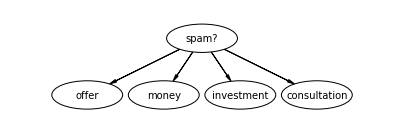

In [10]:
%matplotlib inline
import examples.pgm_diagram_example

examples.pgm_diagram_example.run()

**TODO**: Explain PGM.

**TODO**: Show that $\prob{C \condbar w_i}$ is inaccurate.